In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import sys

In [5]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
# Hyper-parameters
num_epochs = 20
batch_size = 64
learning_rate = 0.01

In [7]:
# Define the path to your dataset folder
dataset_path = 'dataset_256X256'

In [9]:
# Image preprocessing modules
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomPerspective(distortion_scale=0.6, p=0.2),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.Pad(4),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=(0.75, 1.25)),
    transforms.ToTensor()])


transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()])

In [11]:
# Load the training dataset
train_dataset = ImageFolder(root=dataset_path + "/train", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Load the testing dataset
test_dataset = ImageFolder(root=dataset_path + "/test", transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(residual)
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, num_classes=4):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(64, 2)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
    
    def _make_layer(self, out_channels, num_blocks, stride=1):
        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [13]:
model = ResNet().to(device)

In [14]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [16]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [17]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
predicted_labels = []
true_labels = []

for epoch in tqdm(range(num_epochs)):
    train_loss = 0.0
    train_correct = 0
    total_train = 0
    
    # Set the model to train mode
    model.train()
    
    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Calculate training loss and accuracy
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
        total_train += labels.size(0)
    
    # Calculate average training loss and accuracy
    train_loss /= total_train
    train_accuracy = train_correct / total_train
    
    val_loss = 0.0
    val_correct = 0
    total_val = 0
    
    # Set the model to evaluation mode
    model.eval()
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Calculate validation loss and accuracy
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()
            total_val += labels.size(0)
            
            # Collect the predicted and true labels
            predicted_labels.extend(predicted.tolist())
            true_labels.extend(labels.tolist())
    
    # Calculate average validation loss and accuracy
    val_loss /= total_val
    val_accuracy = val_correct / total_val
    
    # Append the training and validation losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Append the training and validation accuracies
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
    # Print or log the training and validation loss and accuracy for each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}  Train Accuracy: {train_accuracy:.4f}")
    print(f"Val Loss: {val_loss:.4f}  Val Accuracy: {val_accuracy:.4f}")
    print()
 

  5%|▌         | 1/20 [06:08<1:56:43, 368.59s/it]

Epoch [1/20]
Train Loss: 1.4745  Train Accuracy: 0.3448
Val Loss: 3.0692  Val Accuracy: 0.3862




 10%|█         | 2/20 [12:23<1:51:46, 372.57s/it]

Epoch [2/20]
Train Loss: 1.0882  Train Accuracy: 0.5025
Val Loss: 1.1345  Val Accuracy: 0.5131




 15%|█▌        | 3/20 [18:43<1:46:26, 375.68s/it]

Epoch [3/20]
Train Loss: 1.0252  Train Accuracy: 0.5408
Val Loss: 0.9248  Val Accuracy: 0.6188




 20%|██        | 4/20 [24:56<1:39:58, 374.88s/it]

Epoch [4/20]
Train Loss: 0.9972  Train Accuracy: 0.5613
Val Loss: 1.0795  Val Accuracy: 0.5450




 25%|██▌       | 5/20 [31:11<1:33:43, 374.88s/it]

Epoch [5/20]
Train Loss: 0.9673  Train Accuracy: 0.5929
Val Loss: 1.0182  Val Accuracy: 0.5619




 30%|███       | 6/20 [37:29<1:27:40, 375.77s/it]

Epoch [6/20]
Train Loss: 0.9212  Train Accuracy: 0.6025
Val Loss: 1.1558  Val Accuracy: 0.5763




 35%|███▌      | 7/20 [43:45<1:21:25, 375.77s/it]

Epoch [7/20]
Train Loss: 0.9000  Train Accuracy: 0.6123
Val Loss: 1.1972  Val Accuracy: 0.5606




 40%|████      | 8/20 [50:01<1:15:12, 376.00s/it]

Epoch [8/20]
Train Loss: 0.9038  Train Accuracy: 0.6117
Val Loss: 0.8788  Val Accuracy: 0.6544




 45%|████▌     | 9/20 [56:17<1:08:55, 375.96s/it]

Epoch [9/20]
Train Loss: 0.8478  Train Accuracy: 0.6390
Val Loss: 0.9563  Val Accuracy: 0.6125




 50%|█████     | 10/20 [1:02:32<1:02:37, 375.78s/it]

Epoch [10/20]
Train Loss: 0.8247  Train Accuracy: 0.6567
Val Loss: 0.9207  Val Accuracy: 0.6687




 55%|█████▌    | 11/20 [1:08:48<56:21, 375.75s/it]  

Epoch [11/20]
Train Loss: 0.7936  Train Accuracy: 0.6604
Val Loss: 0.9132  Val Accuracy: 0.6869




 60%|██████    | 12/20 [1:15:04<50:07, 375.88s/it]

Epoch [12/20]
Train Loss: 0.7691  Train Accuracy: 0.6902
Val Loss: 0.8387  Val Accuracy: 0.6737




 65%|██████▌   | 13/20 [1:21:24<43:59, 377.09s/it]

Epoch [13/20]
Train Loss: 0.7596  Train Accuracy: 0.6842
Val Loss: 0.7568  Val Accuracy: 0.6956




 70%|███████   | 14/20 [1:27:44<37:46, 377.82s/it]

Epoch [14/20]
Train Loss: 0.7491  Train Accuracy: 0.6900
Val Loss: 0.8684  Val Accuracy: 0.6750




 75%|███████▌  | 15/20 [1:34:06<31:36, 379.33s/it]

Epoch [15/20]
Train Loss: 0.7212  Train Accuracy: 0.6994
Val Loss: 0.6864  Val Accuracy: 0.7369




 80%|████████  | 16/20 [1:40:30<25:22, 380.58s/it]

Epoch [16/20]
Train Loss: 0.6943  Train Accuracy: 0.7135
Val Loss: 0.8354  Val Accuracy: 0.6875




 85%|████████▌ | 17/20 [1:47:00<19:10, 383.46s/it]

Epoch [17/20]
Train Loss: 0.6828  Train Accuracy: 0.7181
Val Loss: 0.9245  Val Accuracy: 0.6919




 90%|█████████ | 18/20 [1:53:33<12:52, 386.36s/it]

Epoch [18/20]
Train Loss: 0.6787  Train Accuracy: 0.7181
Val Loss: 0.7380  Val Accuracy: 0.7262




 95%|█████████▌| 19/20 [2:00:03<06:27, 387.37s/it]

Epoch [19/20]
Train Loss: 0.6729  Train Accuracy: 0.7327
Val Loss: 0.7945  Val Accuracy: 0.6881




100%|██████████| 20/20 [2:06:28<00:00, 379.42s/it]

Epoch [20/20]
Train Loss: 0.6495  Train Accuracy: 0.7410
Val Loss: 0.8418  Val Accuracy: 0.7288



In [19]:
# Save the trained model
torch.save(model.state_dict(), 'resnet_modelState.pth')

# torch.save(model,'resnet_model111.pth')

In [20]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))


Accuracy of the model on the test images: 72.875 %


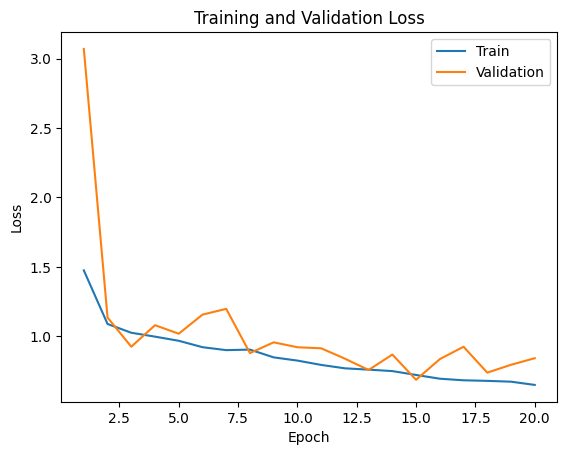

In [24]:
# Plot the training and validation loss
plt.plot(range(1, num_epochs + 1), train_losses, label='Train')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
# plt.show()
plt.savefig('Training_Validation_Loss.png')

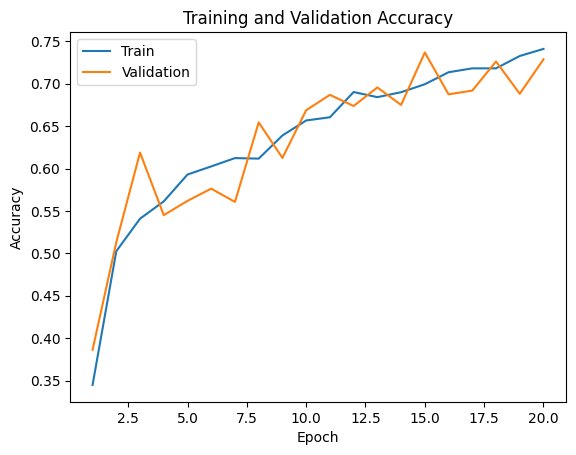

In [25]:
# Plot the training and validation accuracy
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
# plt.show()
plt.savefig('Training_Validation_Accuracy.png')



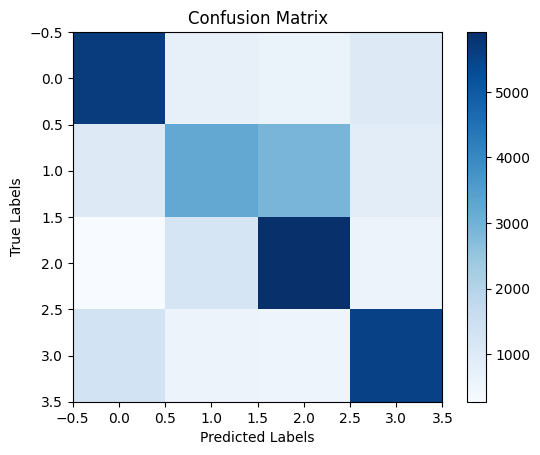

In [26]:
# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.colorbar()
# plt.show()
plt.savefig('ConfusionMatrix.png')